# Predicting ground states for 2D Heisenberg models

In [1]:
# Basic functionalities
import numpy as np
import random
import copy
import ast
import datetime as dt
from timeit import default_timer as timer
from os import path

# Neural tangent kernel
import jax
from neural_tangents import stax

# Traditional ML methods and techniques
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import datasets
from sklearn import svm
from sklearn import linear_model
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor

In [2]:
# Load data

length = 5 # length = 4, 5, 6, 7, 8, 9 for orig; only 4, 5, 6, 7 for new
width = 5

Xfull = [] # Shape = (number of data) x (number of params)
Ytrain = [] # Shape = (number of data) x (number of pairs), estimated 2-point correlation functions
Yfull = [] # Shape = (number of data) x (number of pairs), exact 2-point correlation functions

def get_path_prefix(data='orig'):
    prefix = './heisenberg_data/heisenberg_{}x{}'.format(length, width)
    if data == 'new':
        prefix = './new_data/data_{}x{}/simulation_{}x{}'.format(length, width, length, width)
    return prefix
    
prefix = get_path_prefix(data='orig')

for idx in range(1, 101):
    if path.exists('{}_id{}_XX.txt'.format(prefix, idx)) == False:
        continue
    with open('{}_id{}_samples.txt'.format(prefix, idx), 'r') as f:
        single_data = []
        classical_shadow = [[int(c) for i, c in enumerate(line.split("\t"))] for line in f]
        for i in range(length * 5):
            for j in range(length * 5):
                if i == j:
                    single_data.append(1.0)
                    continue
                corr = 0
                cnt = 0
                for shadow in classical_shadow:
                    if shadow[i] // 2 == shadow[j] // 2:
                        corr += 3 if shadow[i] % 2 == shadow[j] % 2 else -3
                    cnt += 1
                single_data.append(corr / cnt)
        Ytrain.append(single_data)
    with open('{}_id{}_XX.txt'.format(prefix, idx), 'r') as f:
        single_data = []
        for line in f:
            for i, c in enumerate(line.split("\t")):
                v = float(c)
                single_data.append(v)
        Yfull.append(single_data)
    with open('{}_id{}_couplings.txt'.format(prefix, idx), 'r') as f:
        single_data = []
        for line in f:
            for i, c in enumerate(line.split("\t")):
                v = float(c)
                single_data.append(v)
        Xfull.append(single_data)

In [3]:
# Print information

Xfull = np.array(Xfull)
print("number of data (N) * number of params (m) =", Xfull.shape)
Ytrain = np.array(Ytrain)
Yfull = np.array(Yfull)
print("number of data (N) * number of pairs =", Yfull.shape)

print(Xfull[0])
print(Yfull[0].reshape((length * width, length * width)))

number of data (N) * number of params (m) = (100, 40)
number of data (N) * number of pairs = (100, 625)
[1.18168928 1.53359407 1.13247483 0.92017068 1.58805142 1.70829318
 0.40117207 0.59722856 0.49367437 1.15934447 1.2977639  0.02181178
 0.13284607 1.91350673 1.29338196 0.22497174 0.5520419  1.30332841
 0.11328494 1.68542723 1.90099681 1.92933955 1.89155081 1.57980737
 1.64232084 0.06832022 0.18908898 0.62985245 0.2556198  0.74837343
 1.8622303  0.87787792 0.49372496 0.02363917 0.09208565 0.99233735
 1.46400076 0.59811505 0.89836422 1.75019253]
[[ 1.         -0.73436612  0.14878191 -0.14474995  0.11599709 -0.51605336
   0.32365434 -0.12358112  0.12112099 -0.05463596  0.18792915 -0.12781164
   0.10564007 -0.07023125  0.05846915 -0.17445307  0.10474938 -0.10094832
   0.07327367 -0.10863695  0.07434811 -0.08728181  0.09408097 -0.0677407
   0.05352717]
 [-0.73436612  1.         -0.20002065  0.14759701 -0.11141567  0.30457656
  -0.54234347  0.1239137  -0.12261061  0.05123172 -0.16410197  0

In [4]:
# Normalize Xfull

xmin = np.amin(Xfull)
xmax = np.amax(Xfull)

# normalize so that all entries are between -1 and 1 using min-max feature scaling
Xfull_norm = np.array(list(map(lambda row : list(map(lambda x : -1 + 2*(x - xmin)/(xmax - xmin), row)), Xfull)))

print(Xfull_norm[0])

[ 0.18172793  0.53367198  0.132508   -0.07981983  0.5881354   0.70839057
 -0.59887633 -0.40279798 -0.50636371  0.15938063  0.2978155  -0.97827893
 -0.86723225  0.913627    0.29343307 -0.77509631 -0.44798967  0.30338063
 -0.88679557  0.68552207  0.9011157   0.92946159  0.89166864  0.57989042
  0.64241087 -0.93176531 -0.81098308 -0.37017045 -0.74444484 -0.25163625
  0.86234486 -0.12211731 -0.50631312 -0.97645134 -0.90799722 -0.00764512
  0.4640709  -0.40191138 -0.10162873  0.75029459]


In [5]:
# Categorizing pairs of qubits by distance

# grid of qubits
grid = np.array(range(1, length * width + 1)).reshape((length, width))

# generate all edges in grid in same order as Xfull
all_edges = []
for i in range(0, length):
    for j in range(1, width + 1):
        if i != length - 1:
            all_edges.append((width * i + j, width * (i + 1) + j))
        if j != width:
            all_edges.append((width * i + j, width * i + j + 1))

def calc_distance(q1, q2):
    # Given two qubits q1, q2 (1-indexed integers) in length x width grid
    # Output l1 distance between q1 and q2 in grid

    pos1 = np.array(np.where(grid == q1)).T[0]
    pos2 = np.array(np.where(grid == q2)).T[0]

    return np.abs(pos1[0] - pos2[0]) + np.abs(pos1[1] - pos2[1])

def get_nearby_qubit_pairs(d):
    # Given distance d > 0
    # Output all pairs of qubits that are within distance d of each other
    
    if delta1 == 1:
        return all_edges
    
    qubit_pairs = []
    for q1 in range(1, length * width + 1):
        for q2 in range(1, length * width + 1):
            dist = calc_distance(q1, q2)
            pair = tuple(sorted((q1, q2)))
            if dist == d and pair not in qubit_pairs:
                qubit_pairs.append(pair)
    
    return qubit_pairs
            

In [6]:
# Finding local patches of a given radius

def get_local_region_qubits(q, delta1):
    # Given a qubit q (1-indexed integer) in length x width grid and radius delta1
    # delta1 = -1 if all qubits are in local region
    # Output list of qubits (1-indexed integers) within a radius of delta1 of q
    
    if delta1 == 0:
        return [q]
    elif delta1 == -1:
        return list(range(1, length * width + 1))
    
    local_qubits = []
    for q2 in range(1, length * width + 1):
        dist = calc_distance(q, q2)
        
        if dist <= delta1:
            local_qubits.append(q2)
    
    return local_qubits

def get_local_region_edges(q1, q2, delta1):
    # Given two qubits q1, q2 (1-indexed integers) in length x width grid and radius delta1
    # delta1 = -1 if all qubits are in local region
    # Output list of tuples of qubits (1-indexed integers) corresponding to edges in local region of radius delta1

    if delta1 == 0:
        return [(q1, q2)]
    elif delta1 == -1:
        return all_edges

    local_qubits = list(set(get_local_region_qubits(q1, delta1) + get_local_region_qubits(q2, delta1)))
    
    local_edges = []
    for edge in all_edges:
        (q1, q2) = edge
        if q1 in local_qubits and q2 in local_qubits:
            local_edges.append(edge)

    return local_edges

def get_local_region_params(q1, q2, delta1, data):
    # Given two qubits q1, q2 (1-indexed integers) in length x width grid, radius delta1, and input data (i.e., Xfull)
    # delta1 = -1 if all qubits are considered nearby
    # Output data but only for parameters corresponding to edges within radius delta1
    
    edges = get_local_region_edges(q1, q2, delta1)
    
    indices = [all_edges.index(edge) for edge in edges]
    
    return np.array([[data[i][j] for j in sorted(indices)] for i in range(len(data))])
    

In [105]:
print('edges: ' + str(get_local_region_edges(1,2,1)))
print('params: ' + str(get_local_region_params(1,2,1, Xfull_norm)))

edges: [(1, 6), (1, 2), (2, 7), (2, 3), (6, 7)]
params: [[ 0.18172793  0.53367198  0.132508   -0.07981983  0.2978155 ]
 [ 0.24027618  0.32291227  0.51701503  0.90849435 -0.31575018]
 [ 0.93253616  0.48279795  0.70894932  0.78024967 -0.4091931 ]
 [ 0.66401033  0.37970161 -0.63184338 -0.72879382 -0.92541011]
 [-0.15007934  0.55074239 -0.6021703  -0.90526384  0.92221436]
 [ 0.24863373 -0.16219988 -0.58238148 -0.08646597 -0.70895066]
 [ 0.93259946 -0.1399933   0.52063176  0.13093541  0.12741486]
 [-0.24006965  0.33576741 -0.1647002   0.86241386 -0.69655814]
 [ 0.97410305 -0.33389531  0.57857694  0.85998422 -0.83209658]
 [-0.09615202  0.52335851  0.7451496  -0.83416239 -0.63860991]
 [ 0.0152768   0.4310106  -0.56565964  0.70936891 -0.07067123]
 [ 0.27882615  0.55720674 -0.08026133  0.95337862 -0.5317155 ]
 [ 0.29648599 -0.21867868  0.59151375  0.49696129  0.0690236 ]
 [ 0.09378365 -0.07076485  0.84782197 -0.81035305 -0.20156205]
 [-0.68168293  0.13492275 -0.06492154 -0.65412708 -0.52684124]

In [41]:
# Feature mapping

def get_feature_vectors(delta1, R, data, omega):
    # Given radius delta1 and hyperparameter R (number of nonlinear features per local region), input data, and fixed randomness omega
    # delta1 = -1 if all qubits are considered nearby
    # Output concatenated feature vectors
    
    # to store all concatenated feature vectors
    all_feature_vectors = []
    
    for i in range(len(data)):
        feature_vector_concat = []
        # iterate over all possible local regions
        n = len(all_edges)
        for k in range(n):
            (q1, q2) = all_edges[k]
            data_local = get_local_region_params(q1, q2, delta1, data)[i]
            m_local = len(data_local)

            # do nonlinear feature map on each vector in data_local
            feature_vector = []
            
            for j in range(R):
                omega_j = omega[k][j]
                val = np.exp(np.dot(omega_j, data_local) * 1j) / np.sqrt(R)
                feature_vector.append(np.real(val))
                feature_vector.append(np.imag(val))

            # concatenate feature vectors together
            feature_vector_concat += feature_vector
            
        all_feature_vectors.append(feature_vector_concat)
        
    # note all_feature_vectors is of size number of data (N) x (2 * R * number of local regions)
    return np.array(all_feature_vectors)
        

In [ ]:
# Training and testing algorithm

# set size of local region
delta1 = 1

# set max number of feature entries
max_R_idx = 5
max_R = 5 * 2 ** (max_R_idx - 1)

# set of pairs of qubits we care about predicting correlation function for
qubits = get_nearby_qubit_pairs(1)

train_idx, test_idx, _, _ = train_test_split(range(len(Xfull)), range(len(Xfull)), test_size=0.4, random_state=0)

# generate omega to pass into feature mapping
omega = []
for (q1, q2) in all_edges: # TODO: change this as well when changing feature mapping
    m_local = len(get_local_region_edges(q1, q2, delta1))
    omega_sub = []
    for j in range(max_R):
        omega_sub.append(np.random.normal(0, 1, m_local))
    omega.append(omega_sub)

for (q1, q2) in qubits:
    print('(q1, q2) =', (q1, q2))

    def train_and_predict():
        # consider the pair (q1, q2)
        global q1, q2
        
        # training data (estimated from measurement data)
        y = np.array([Ytrain[i].reshape((length * width, length * width))[q1 - 1][q2 - 1] for i in range(len(Xfull))])
        X_train, X_test, y_train, y_test = train_test_split(Xfull_norm, y, test_size=0.4, random_state=0)

        # testing data (exact expectation values)
        y_clean = np.array([Yfull[i].reshape((length * width, length * width))[q1 - 1][q2 - 1] for i in range(len(Xfull))])
        _, _, _, y_test_clean = train_test_split(Xfull_norm, y_clean, test_size=0.4, random_state=0)

        # use cross validation to find the best hyperparameters
        best_cv_score, test_score = 999.0, 999.0
        ML_method = lambda Cx : linear_model.Lasso(alpha=Cx)
        range_R = [5 * 2 ** i for i in range(max_R_idx)]
        for R in range_R:
            # feature mapping
            Xfeature_train = get_feature_vectors(delta1, R, X_train, omega)
            Xfeature_test = get_feature_vectors(delta1, R, X_test, omega)
            
            for C in [0.0125, 0.025, 0.05, 0.125, 0.25, 0.5, 1.0, 2.0]:
                score = -np.mean(cross_val_score(ML_method(C), Xfeature_train, y_train, cv=5, scoring="neg_root_mean_squared_error"))
                if best_cv_score > score:
                    clf = ML_method(C).fit(Xfeature_train, y_train.ravel())
                    test_score = np.linalg.norm(clf.predict(Xfeature_test).ravel() - y_test_clean.ravel()) / (len(y_test) ** 0.5)
                    best_cv_score = score
                
        return best_cv_score, test_score

    print(train_and_predict())

(q1, q2) = (1, 6)
(0.16037427338731985, 0.17660028023158644)
(q1, q2) = (1, 2)
(0.16767400087451073, 0.181341708632325)
(q1, q2) = (2, 7)
(0.1250197570422209, 0.1156119782523804)
(q1, q2) = (2, 3)


# Classifying topological-ordered and trivial phases

In [39]:
# Kernel PCA from sklearn
import numpy as np
from sklearn.decomposition import PCA

# Plotting tools
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("ticks")

In [51]:
# Load the shadow kernel matrix (for 100 different states; 50 topological, 50 trivial)
with open('topological_alldep_tr=10.txt', 'r') as f:
    all_K = ast.literal_eval(f.read())

# Perform kernel PCA based on shadow kernel
data = []
for d, K in enumerate(all_K[:-1]):
    X = []
    orig_id = []
    for i in range(len(K)):
        orig_id.append(i)
        single_X = []
        for j in range(len(K)):
            single_X.append(K[i][j] / ((K[i][i] * K[j][j]) ** 0.5))
        X.append(single_X)

    X = np.array(X)
    pca = PCA(n_components=1)
    F = pca.fit_transform(X)
    std = np.std(F)
    
    for z in range(len(X)):
        i = orig_id[z]
        if d == 0 or d == 9:
            data.append((-F[z, 0] / std, d, "Topological" if z < 5 else "Trivial"))
        else:
            data.append((F[z, 0] / std, d, "Topological" if z < 5 else "Trivial"))


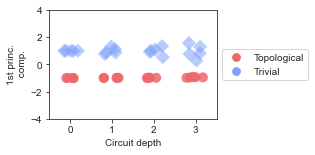

In [52]:
# Plot the 1D representation for different circuit depth
plt.figure(figsize=(3.0, 2.0))
df_toric = pd.DataFrame(data=data, columns = ['PC1', 'Depth', 'Phase'])
ax = sns.stripplot(x="Depth", y="PC1", hue='Phase', data=df_toric[df_toric["Phase"]=="Topological"], palette=['#ED686D'], orient="v",
                   edgecolor="black", marker="o", s=10, alpha=0.85, jitter=0.22)
ax = sns.stripplot(x="Depth", y="PC1", hue='Phase', data=df_toric[df_toric["Phase"]=="Trivial"], palette=['#80A3FA'], orient="v",
                   edgecolor="black", marker="D", s=10, alpha=0.55, jitter=0.22)

ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)
ax.set_xlabel("Circuit depth")
ax.set_ylabel("1st princ.\n comp.")
ax.set_ylim(-4.0, 4.0);
